In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.hdf5_io import DataStorage
from mesostat.stat.anova import as_pandas, as_pandas_lst, anova_homebrew

from lib.sych.data_fc_db_raw import DataFCDatabase
from lib.sych.plot_helper import imshow_dataset_by_mouse, imshow_dataset_by_session
from lib.sych.metric_helper import metric_by_session

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data'] = './'
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed'
# params['root_path_data'] = gui_fpath('h5path', './')

In [3]:
dataDB = DataFCDatabase(params)

Searching for data files
Extracting trial type names
Extracting data types


In [4]:
ds = DataStorage('sych_result_individual_region.h5')

In [5]:
mc = MetricCalculator(serial=True, verbose=False)

In [6]:
print(dataDB.mice)
print(dataDB.dataTypes)
print(dataDB.trialTypeNames)

{'mvg_7', 'mvg_4', 'mvg_8', 'mvg_9'}
{'bn_trial', 'bn_session', 'raw'}
{'iGO', 'iNOGO', 'iMISS', 'iFA'}


# Analysis of Variance

* Across sessions
    - Explained by performance
* Across channels, trials, timesteps
    - Explained by trial type

Things to understand:
* How to compare different rows?
* What models make sense?
* Try linear mixed models?

In [7]:
intervDict = {
    'PRE' : (-2.0, 0.0),
    'TEX' : (3.0, 3.5),
    'REW' : (6.0, 6.5)
}

#trialTypeNames = dataDB.get_trial_type_names()
trialTypeNames = ['iGO', 'iNOGO']

dfDict = {}
for mousename in dataDB.mice:
    sessions = dataDB.get_sessions(mousename)
    dfThis = pd.DataFrame()
    for session in sessions:
        for trialType in trialTypeNames:
            dataTrialLst = []
            for intervName, interv in intervDict.items():
                data = dataDB.get_neuro_data({'session' : session}, datatype='bn_session', trialType=trialType, cropTime=interv)[0]
                data = np.mean(data, axis=1)  # Average over timesteps
                dataDF = as_pandas(data, ('trials', 'channels'))
                dataDF['trialType'] = trialType
                dataDF['interval'] = intervName
                dataDF['session'] = session
                dfThis = dfThis.append(dataDF, ignore_index=True)
            
    dfThis = dfThis.drop('trials', axis=1)
    dfDict[mousename] = dfThis

In [8]:
model = '''
    rez ~ C(channels)
    + C(trialType)
    + C(interval)
    + C(session)
    + C(trialType)*C(session)
    + C(trialType)*C(channels)
    + C(interval)*C(channels)
'''

# Session-wide
for mousename in sorted(dataDB.mice):
    print(mousename)
    linModel = ols(model, data=dfDict[mousename]).fit()
    display(sm.stats.anova_lm(linModel, typ=1))

mvg_4


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),47.0,0.749293,0.015942,107.005456,0.000000e+00
C(trialType),1.0,1.973377,1.973377,13245.318799,0.000000e+00
C(interval),2.0,11.287720,5.643860,37881.620934,0.000000e+00
C(session),10.0,0.032350,0.003235,21.713295,4.331705e-41
C(trialType):C(session),10.0,0.140774,0.014077,94.487868,1.989006e-196
C(trialType):C(channels),47.0,5.778230,0.122941,825.181116,0.000000e+00
C(interval):C(channels),94.0,13.725373,0.146015,980.050930,0.000000e+00
Residual,611932.0,91.169763,0.000149,NaN,NaN


mvg_7


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),47.0,0.499883,0.010636,92.219966,0.000000e+00
C(trialType),1.0,1.136057,1.136057,9850.410226,0.000000e+00
C(interval),2.0,2.758569,1.379285,11959.360487,0.000000e+00
C(session),17.0,0.041750,0.002456,21.294465,1.637029e-66
C(trialType):C(session),17.0,0.123520,0.007266,63.000237,8.592165e-217
C(trialType):C(channels),47.0,0.940339,0.020007,173.476506,0.000000e+00
C(interval):C(channels),94.0,5.070384,0.053940,467.699606,0.000000e+00
Residual,690977.0,79.691049,0.000115,NaN,NaN


mvg_8


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),47.0,0.794119,0.016896,71.332794,0.000000e+00
C(trialType),1.0,1.231691,1.231691,5200.003127,0.000000e+00
C(interval),2.0,20.350952,10.175476,42959.230324,0.000000e+00
C(session),15.0,0.175737,0.011716,49.462272,2.732637e-148
C(trialType):C(session),15.0,0.313283,0.020886,88.175508,1.627001e-272
C(trialType):C(channels),47.0,2.747209,0.058451,246.771827,0.000000e+00
C(interval):C(channels),94.0,12.746297,0.135599,572.476853,0.000000e+00
Residual,527250.0,124.886309,0.000237,NaN,NaN


mvg_9


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),47.0,1.992093,0.042385,35.617110,7.943093e-320
C(trialType),1.0,5.980463,5.980463,5025.528385,0.000000e+00
C(interval),2.0,9.178997,4.589499,3856.667148,0.000000e+00
C(session),20.0,0.339061,0.016953,14.246073,9.804631e-49
C(trialType):C(session),20.0,0.417006,0.020850,17.521001,3.778893e-62
C(trialType):C(channels),47.0,3.993729,0.084973,71.404836,0.000000e+00
C(interval):C(channels),94.0,16.571187,0.176289,148.140119,0.000000e+00
Residual,795944.0,947.186716,0.001190,NaN,NaN


mvg_4
mvg_7
mvg_8
mvg_9


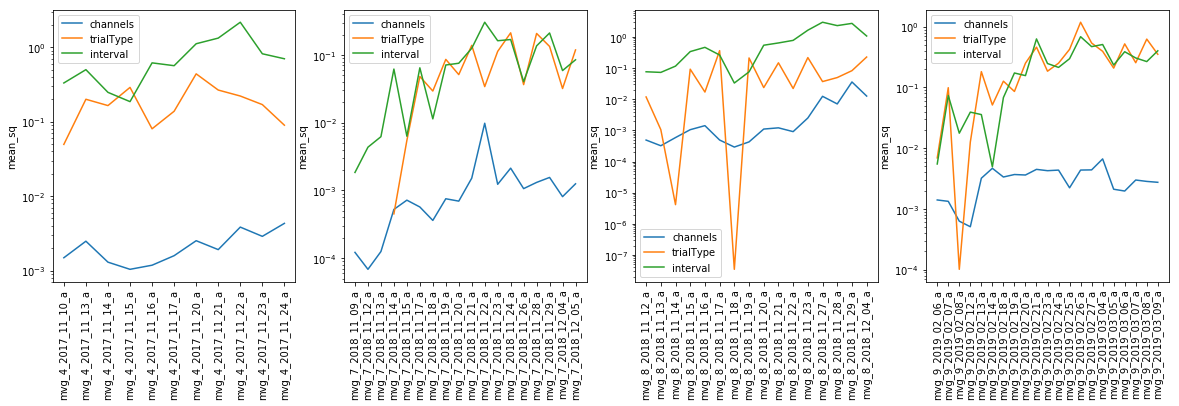

In [9]:
# Across-sessions
nMice = len(dataDB.mice)
fig, ax = plt.subplots(ncols = nMice, figsize=(5*nMice, 5))

model = '''
rez ~ C(channels)+C(trialType)+C(interval)
'''

for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    dfThis = dfDict[mousename]
    print(mousename)
    sessions = dataDB.get_sessions(mousename)
    plotData = []
    for session in sessions:
        dfSession = dfThis[dfThis['session'] == session]
        linModel = ols(model, data=dfSession).fit()
        rezStat = sm.stats.anova_lm(linModel, typ=1)
        rezStat = rezStat.drop('Residual')
        plotData += [np.array(rezStat['mean_sq'])]

    names = ['channels', 'trialType', 'interval']
    plotData = np.array(plotData).T


    ax[iMouse].set_ylabel('mean_sq')
    for name, x in zip(names, plotData):
        ax[iMouse].semilogy(x, label=name)

    ax[iMouse].set_xticks(np.arange(len(sessions)))
    ax[iMouse].set_xticklabels(sessions, rotation=90)
    ax[iMouse].legend()

plt.savefig('pics/ANOVA_by_session.png')
plt.show()
plt.close()